# Symulacje GAN

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
from tqdm import tqdm
import scipy
from scipy import integrate
from scipy import stats
from matplotlib.ticker import MaxNLocator

import networkx as nx
import datgan
from datgan import DATGAN
from scipy.special import digamma, gamma

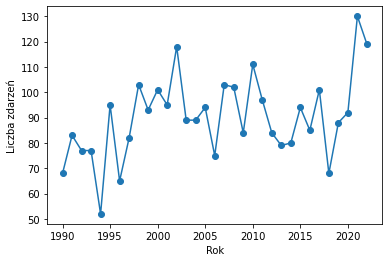

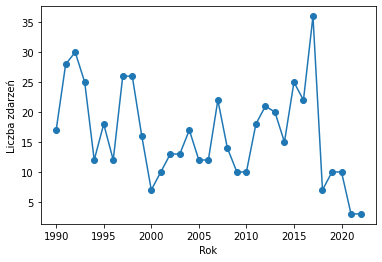

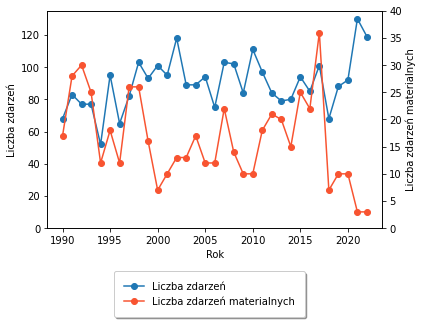

C:\Users\ndzad\AppData\Local\Temp/ipykernel_12560/3110197025.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


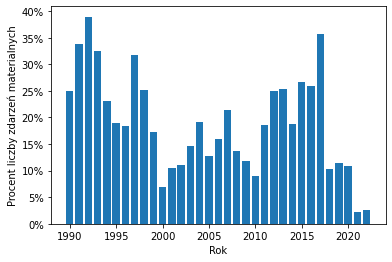

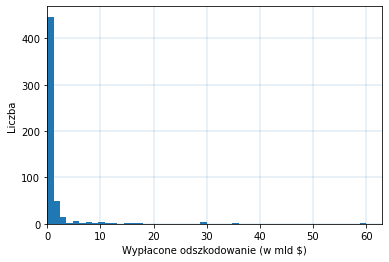

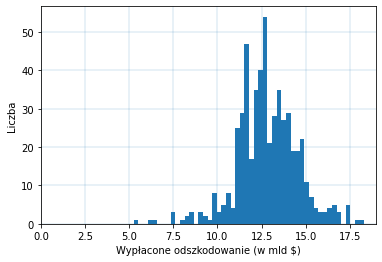

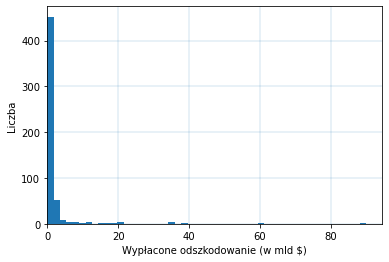

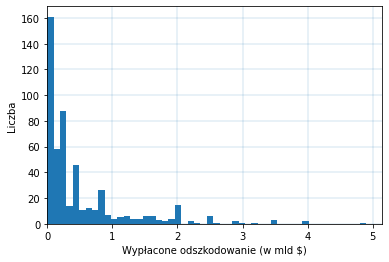

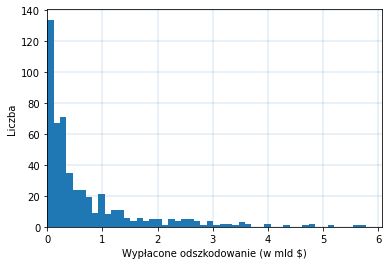

In [117]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\DataPreparation.ipynb"

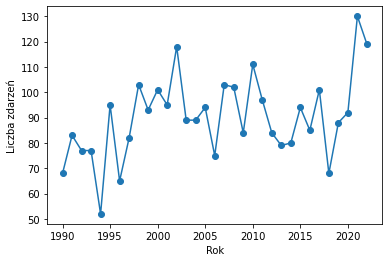

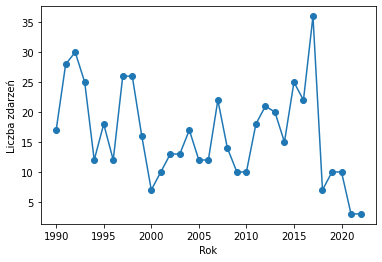

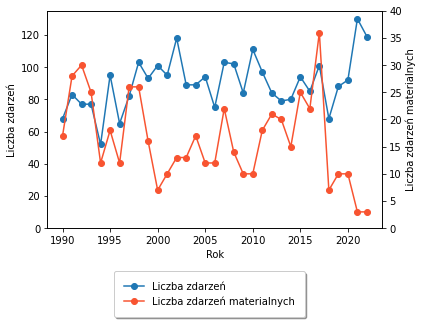

C:\Users\ndzad\AppData\Local\Temp/ipykernel_12560/3110197025.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


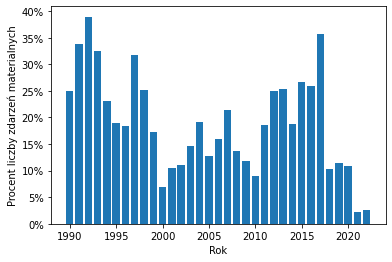

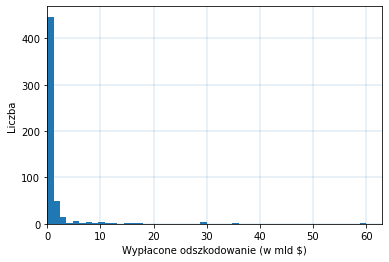

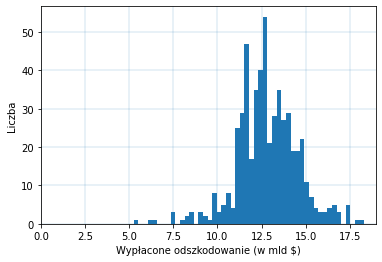

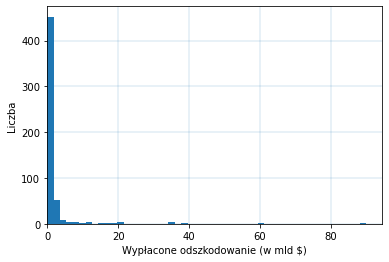

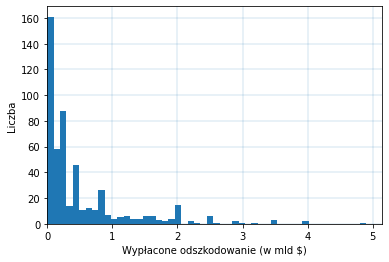

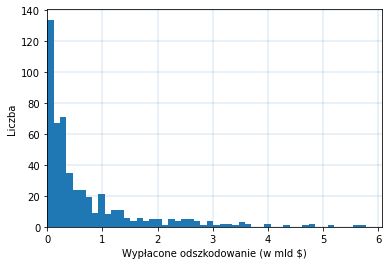

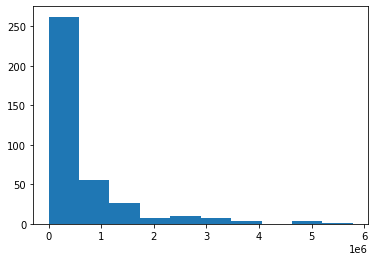

1.667e-06


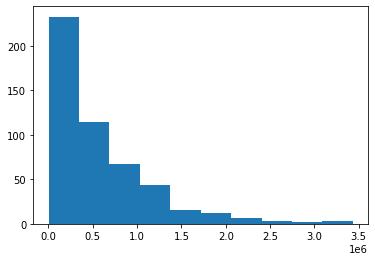

       rozkład test  Wartość statystyki       p value
0  Wykładniczy   KS                0.18  6.769813e-11
1  Wykładniczy   CM                3.06  5.051111e-08
12.47 2.07
12.46672547764283 2.074318127197053


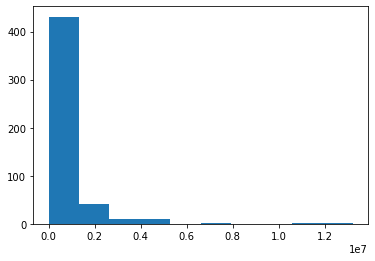

       rozkład test  Wartość statystyki   p value
0  Lognormalny   KS                0.06  0.120754
1  Lognormalny   CM                0.21  0.244276
0.72 1.1988586302925719e-06


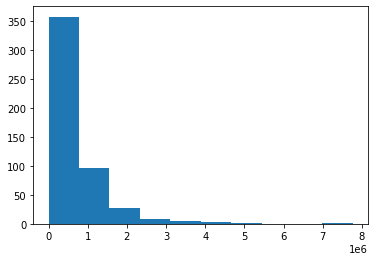

  rozkład test  Wartość statystyki   p value
0   Gamma   KS                0.13  0.000012
1   Gamma   CM                1.02  0.002138
0.786188921301622 514170.5554941683


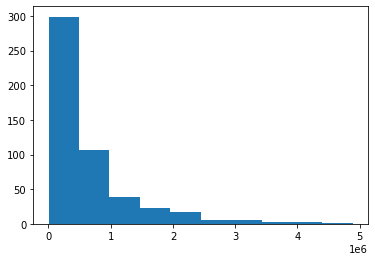

    rozkład test  Wartość statystyki   p value
0  Weibulla   KS                0.10  0.001004
1  Weibulla   CM                0.59  0.023748


c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


1.861639368063435 0.043086409391061675
  rozkład test  Wartość statystyki       p value
0   Burra   KS                0.51  4.854888e-90
1   Burra   CM               29.38  4.346694e-09
       rozkład test  Wartość statystyki       p value
0  Wykładniczy   KS                0.18  6.769813e-11
1  Wykładniczy   CM                3.06  5.051111e-08
2  Lognormalny   KS                0.06  1.207536e-01
3  Lognormalny   CM                0.21  2.442758e-01
4        Gamma   KS                0.13  1.164551e-05
5        Gamma   CM                1.02  2.137666e-03
6     Weibulla   KS                0.10  1.004223e-03
7     Weibulla   CM                0.59  2.374758e-02
8        Burra   KS                0.51  4.854888e-90
9        Burra   CM               29.38  4.346694e-09


In [189]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_odszkodowan.ipynb"

In [2]:
T = pd.DataFrame({'t':[1990 + t/365 for t in range((datetime.datetime(1990,12,31)-datetime.datetime(1990,1,1)).days+1)]})
for r in range(1991,2023):
    if r%4==0:
        T = pd.concat([T,pd.DataFrame({'t':[r + t/366 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
    else:
        T = pd.concat([T,pd.DataFrame({'t':[r + t/365 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
T.reset_index(drop=True,inplace=True)

In [6]:
N = pd.merge(T, data_wo[['t','Ind']], on='t', how='left').fillna(0).groupby('t').sum().cumsum().assign(Year=np.floor(pd.merge(T, data_wo[['t','Ind']], on='t', how='left')['t']))
N = N.assign(Year=np.floor(N.index))
n = N.groupby('Year').max('Ind').diff().fillna(float(N.groupby('Year').max('Ind').head(1)['Ind'])).rename(columns = {'Ind':'n'})

T_train = T[T['t']<2013]
t_train = T_train['t'] - 1990
n_train = n[n.index<=2012]
N_train = N[N['Year']<=2012]

T_test = T[T['t']>=2013]
t_test = T_test['t'] - 2013
n_test = n[n.index>2012]
N_test = N[N['Year']>2012]

In [7]:
data_to_gan = train[["Insured Damages, Adjusted (\'000 US$)","t"]].rename(columns={"Insured Damages, Adjusted (\'000 US$)":"Damages"}).dropna()

In [8]:
data_info = {
    'Damages': {
        'type': 'continuous',
        'bounds': [0.0, np.infty],
        'discrete': False
    },
    't': {
        'type': 'continuous',
        'bounds': [1990, 2013],
        'discrete': False,
        'enforce_bounds': True
    }
}

In [9]:
graph = nx.DiGraph()
graph.add_node("Damages")
graph.add_node("t")

In [10]:
continuous_columns = ["Damages", "t"]

In [50]:
datgan = DATGAN(batch_size=11, num_epochs=1000)

In [51]:
datgan.fit(data_to_gan, data_info, graph)

Preprocessed data have been loaded!
Start training DATGAN with the WGGP loss (15/05/2023 17:54:19).
Restored models from epoch 1000.


Training DATGAN: 0it [00:00, ?it/s]

DATGAN has finished training (15/05/2023 17:54:20) - Training time: 00 second


In [52]:
samples = datgan.sample(num_samples=len(train))
samples.to_csv(r'C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\synthetic.csv', index=False)

Sampling from DATGAN: 100%|██████████| 375/375 [00:02<00:00, 163.24it/s]


### Wartość odszkodowań

In [63]:
number_of_simulations = 500

In [64]:
exp_lambda_gan = []
ln_mu_gan = []
ln_sigma_sq_gan = []
gamma_alfa_gan = []
gamma_beta_gan = []
weibull_k_gan = []
weibull_lambda_gan = []
burr_c_gan = []
burr_k_gan = []

for i in range(number_of_simulations):
    damages = datgan.sample(num_samples=len(train))["Damages"]

    exp_lambda_gan.append(len(damages)/sum(damages))
    ln_mu_gan.append(sum(np.log(damages))/len(damages))
    ln_sigma_sq_gan.append(sum(np.square(np.log(damages)-sum(np.log(damages))/len(damages)))/len(damages))
    gamma_alfa_gan.append(stats.gamma.fit(damages,floc=0)[0])
    gamma_beta_gan.append(1/stats.gamma.fit(damages,floc=0)[2])
    weibull_k_gan.append(stats.weibull_min.fit(damages,floc=0)[0])
    weibull_lambda_gan.append(stats.weibull_min.fit(damages,floc=0)[2])
    burr_c_gan.append(stats.burr12.fit(damages,floc=0,fscale=1)[0])
    burr_k_gan.append(stats.burr12.fit(damages,floc=0,fscale=1)[1])

Sampling from DATGAN: 100%|██████████| 375/375 [00:01<00:00, 228.66it/s]
c:\Users\ndzad\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
Sampling from DATGAN: 100%|██████████| 375/375 [00:01<00:00, 281.59it/s]


In [99]:
exp_lambda_gan_avg = np.mean(exp_lambda_gan)
exp_lambda_gan_5p = np.percentile(exp_lambda_gan,95)
exp_lambda_gan_95p = np.percentile(exp_lambda_gan,95)

ln_mu_gan_avg = np.mean(ln_mu_gan)
ln_mu_gan_5p = np.percentile(ln_mu_gan,95)
ln_mu_gan_95p = np.percentile(ln_mu_gan,95)

ln_sigma_sq_gan_avg = np.mean(ln_sigma_sq_gan)
ln_sigma_sq_gan_5p = np.percentile(ln_sigma_sq_gan,95)
ln_sigma_sq_gan_95p = np.percentile(ln_sigma_sq_gan,95)

gamma_alfa_gan_avg = np.mean(gamma_alfa_gan)
gamma_alfa_gan_5p = np.percentile(gamma_alfa_gan,95)
gamma_alfa_gan_95p = np.percentile(gamma_alfa_gan,95)

gamma_beta_gan_avg = np.mean(gamma_beta_gan)
gamma_beta_gan_5p = np.percentile(gamma_beta_gan,95)
gamma_beta_gan_95p = np.percentile(gamma_beta_gan,95)

weibull_k_gan_avg = np.mean(weibull_k_gan)
weibull_k_gan_5p = np.percentile(weibull_k_gan,95)
weibull_k_gan_95p = np.percentile(weibull_k_gan,95)

weibull_lambda_gan_avg = np.mean(weibull_lambda_gan)
weibull_lambda_gan_5p = np.percentile(weibull_lambda_gan,95)
weibull_lambda_gan_95p = np.percentile(weibull_lambda_gan,95)

burr_c_gan_avg = np.mean(burr_c_gan)
burr_c_gan_5p = np.percentile(burr_c_gan,95)
burr_c_gan_95p = np.percentile(burr_c_gan,95)

burr_k_gan_avg = np.mean(burr_k_gan)
burr_k_gan_5p = np.percentile(burr_k_gan,95)
burr_k_gan_95p = np.percentile(burr_k_gan,95)

In [194]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Lognormalny','Lognormalny','Gamma','Gamma','Weibulla','Weibulla','Burra','Burra'],
    'Parametr' : ['lambda',"mu","sigma_sq","alfa","beta","k","lambda","c","k"],
    'Wartość' : [
                    "{:e}".format(exp_lambda_gan_avg),
                    round(ln_mu_gan_avg,2),
                    round(ln_sigma_sq_gan_avg,2),
                    round(gamma_alfa_gan_avg,2),
                    "{:e}".format(gamma_beta_gan_avg),
                    round(weibull_k_gan_avg,2),
                    round(weibull_lambda_gan_avg,2),
                    round(burr_c_gan_avg,2),
                    round(burr_k_gan_avg,2),
        ],
    'Rożnice' : [
                    exp_lambda_gan_avg-exp_lambda,
                    ln_mu_gan_avg-ln_mu,
                    ln_sigma_sq-ln_sigma_sq_gan_avg,
                    gamma_alfa_gan_avg-gamma_alfa,
                    gamma_beta_gan_avg-gamma_beta,
                    weibull_k_gan_avg-weibull_k,
                    weibull_lambda_gan_avg-weibull_lambda,
                    burr_c_gan_avg-burr_c,
                    burr_k_gan_avg-burr_k,                
        ]
}))

       rozkład  Parametr       Wartość       Rożnice
0  Wykładniczy    lambda  1.587222e-06 -8.026576e-08
1  Lognormalny        mu         12.68  2.167651e-01
2  Lognormalny  sigma_sq           1.6  4.716185e-01
3        Gamma      alfa          0.88  1.579749e-01
4        Gamma      beta  1.394750e-06  1.958915e-07
5     Weibulla         k          0.88  9.331578e-02
6     Weibulla    lambda     587007.16  7.283661e+04
7        Burra         c          1.88  1.423371e-02
8        Burra         k          0.04  1.419934e-04


### Liczba odszkodowań

In [90]:
sin_params_gan = []
power_law_params_gan = []

for i in range(number_of_simulations):
    number = nhpp_pred(T_train['t'], datgan.sample(num_samples=len(train))['t'], T_train['t'])
    sin_params_gan.append(scipy.optimize.curve_fit(cum_sin_int_fun, xdata = t_train, ydata = number, method = 'lm')[0])
    power_law_params_gan.append(scipy.optimize.curve_fit(cum_power_law_int_fun, xdata = t_train, ydata = number, method = 'lm')[0])

Sampling from DATGAN: 100%|██████████| 375/375 [00:01<00:00, 243.29it/s]


In [100]:
sin_params_gan_avg = np.mean(sin_params_gan,axis=0)
sin_params_gan_5p = np.percentile(sin_params_gan,95,axis=0)
sin_params_gan_95p = np.percentile(sin_params_gan,95,axis=0)

power_law_params_gan_avg = np.mean(power_law_params_gan,axis=0)
power_law_params_gan_5p = np.percentile(power_law_params_gan,95,axis=0)
power_law_params_gan_95p = np.percentile(power_law_params_gan,95,axis=0)

In [196]:
sin_params = scipy.optimize.curve_fit(cum_sin_int_fun, xdata = t_train, ydata = N_train["Ind"], method = 'lm')[0]
power_law_params = scipy.optimize.curve_fit(cum_power_law_int_fun, xdata = t_train, ydata = N_train["Ind"], method = 'lm')[0]

In [197]:
print(pd.DataFrame
({
    'rozkład':['Sinusoidalna','Sinusoidalna','Sinusoidalna','Power Law','Poawer Law'],
    'Parametr' : ['lambda_0','lambda_1','lambda_2','lambda_0','lambda_1',],
    'Wartość' : [
                round(sin_params_gan_avg[0],2),
                round(sin_params_gan_avg[1],2),
                round(sin_params_gan_avg[2],2),
                round(power_law_params_gan_avg[0],2),
                round(power_law_params_gan_avg[1],2),
                ],
    'Różnice' : [
        sin_params_gan_avg[0]-sin_params[0],
        sin_params_gan_avg[1]-sin_params[1],
        sin_params_gan_avg[2]-sin_params[2],
        power_law_params_gan_avg[0]-power_law_params[0],
        power_law_params_gan_avg[1]-power_law_params[1]

    ]
}))

        rozkład  Parametr  Wartość   Różnice
0  Sinusoidalna  lambda_0    16.61  0.278929
1  Sinusoidalna  lambda_1    10.32 -0.447763
2  Sinusoidalna  lambda_2     0.98 -0.019061
3     Power Law  lambda_0    31.93  0.020387
4    Poawer Law  lambda_1     0.78  0.007624


In [104]:
loss_full = pd.merge(T, data_wo[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_full = loss_full.cumsum()

In [105]:
loss_train = pd.merge(T_train, train[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_train = loss_train.cumsum()

In [106]:
loss_test = pd.merge(T_test, test[['t','Insured Damages, Adjusted (\'000 US$)']], on='t', how='left').fillna(0).groupby('t').sum().rename(columns={'Insured Damages, Adjusted (\'000 US$)':'damages'})
cum_loss_test = loss_test.cumsum()

In [103]:
def loss_pred(t, n, damages, t_index):
    """
    Funkcja generuje proces dla zaobserwowanych zdarzeń.

    Argumenty:
        t: array
            Przestrzeń czasów
        n: array
            Zaobserowane czasy zdarzenia
        damages: array
            Straty
        t_index: array
            Pożądane indeksy
    Zwraca:
        pandas.Series
            Tablica czasów.
    """
    df = pd.DataFrame({'t':n, 'damages':damages}).set_index('t')
    counts = [sum([1 for x in n if x <= y]) for y in t]
    values = [sum([df['damages'][x] for x in n if x <= y]) for y in t]
    return(pd.DataFrame({'n' : counts, 'damages': values}, index = t_index))

## Straty - avg

### Rozkład wykładniczy

Sinusoidalna funkcja intensywności

In [120]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_gan_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_exp_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_exp_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_exp_gan = np.sum(MSE_array)/number_of_simulations
MAE_sin_exp_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [1:11:09<00:00,  8.54s/it]


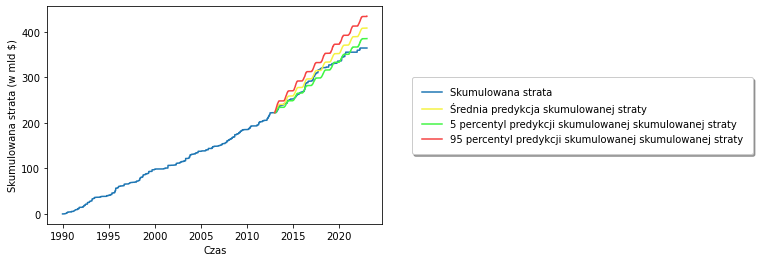

In [165]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_exp_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_exp_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_exp_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_exp_sin_gan_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [122]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_gan_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_exp_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_exp_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_exp_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_exp_gan = np.sum(MSE_array)/number_of_simulations
MAE_power_law_exp_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [36:26<00:00,  4.37s/it]


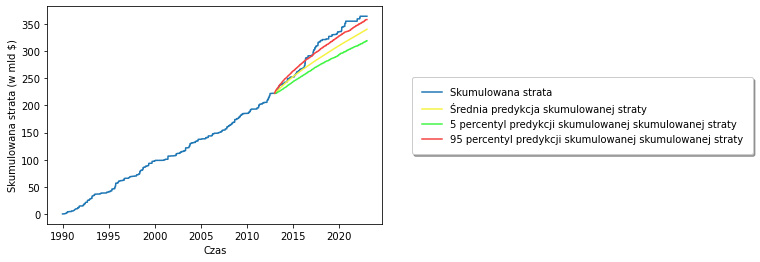

In [166]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_exp_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_exp_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_exp_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_exp_power_law_gan_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład lognormalny

Sinusoidalna funkcja intensywności

In [124]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_gan_avg),scale=np.exp(ln_mu_gan_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_ln_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_ln_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_ln_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_ln_gan = np.sum(MSE_array)/number_of_simulations
MAE_sin_ln_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [53:08<00:00,  6.38s/it] 


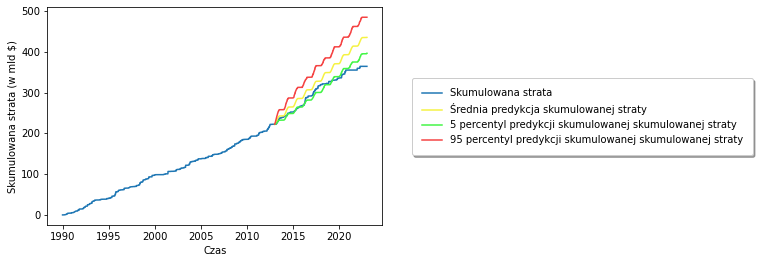

In [167]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_ln_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_ln_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_ln_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_ln_sin_gan_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [126]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_gan_avg),scale=np.exp(ln_mu_gan_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_ln_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_ln_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_ln_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_ln_gan = np.sum(MSE_array)/number_of_simulations
MAE_power_law_ln_gan = np.sum(MAE_array)/number_of_simulations


100%|██████████| 500/500 [35:46<00:00,  4.29s/it]


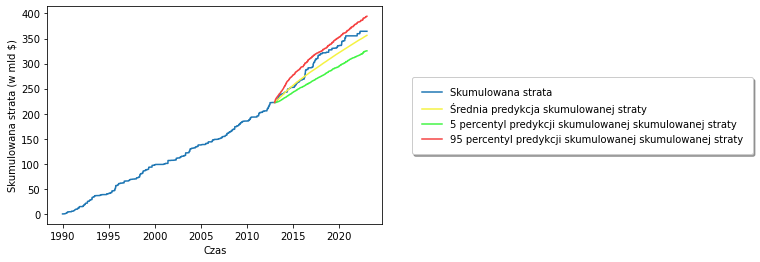

In [168]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_ln_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_ln_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_ln_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_ln_power_law_gan_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Gamma

Sinusoidalna funkcja intensywności

In [128]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_gan_avg,scale=1/gamma_beta_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_gamma_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_gamma_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_gamma_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_gamma_gan = np.sum(MSE_array)/number_of_simulations
MAE_sin_gamma_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [57:06<00:00,  6.85s/it]  


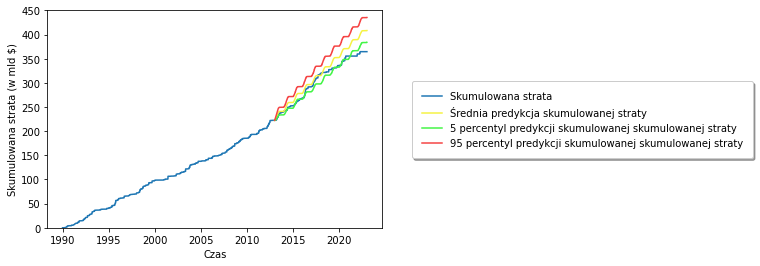

In [185]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_gamma_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_gamma_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_gamma_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_gamma_sin_gan_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [130]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_gan_avg,scale=1/gamma_beta_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_gamma_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_gamma_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_gamma_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_gamma_gan = np.sum(MSE_array)/number_of_simulations
MAE_power_law_gamma_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [36:15<00:00,  4.35s/it]


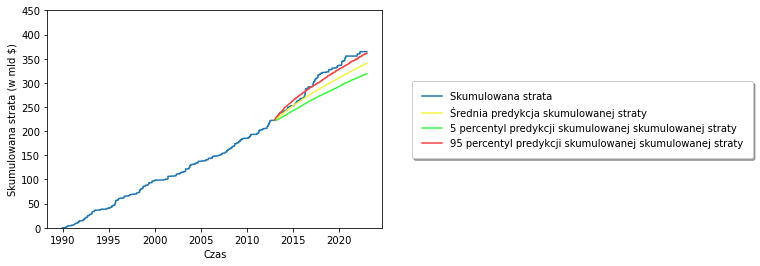

In [186]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_gamma_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_gamma_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_gamma_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_gamma_power_law_gan_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Weibulla

Sinusoidalna funkcja intensywności

In [132]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_gan_avg,scale=weibull_lambda_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_weibull_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_weibull_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_weibull_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_weibull_gan = np.sum(MSE_array)/number_of_simulations
MAE_sin_weibull_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [55:22<00:00,  6.65s/it]


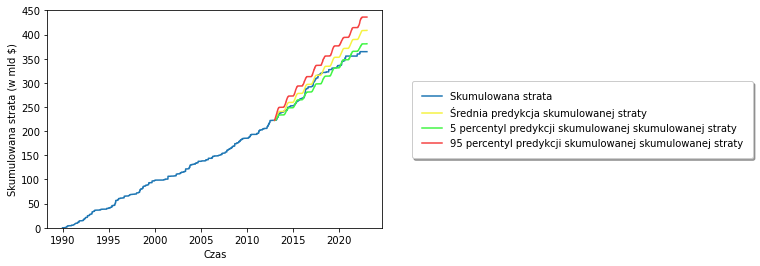

In [187]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_weibull_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_weibull_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_weibull_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_weibull_sin_gan_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [134]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_gan_avg,scale=weibull_lambda_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_weibull_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_weibull_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_weibull_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_weibull_gan = np.sum(MSE_array)/number_of_simulations
MAE_power_law_weibull_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [36:20<00:00,  4.36s/it]


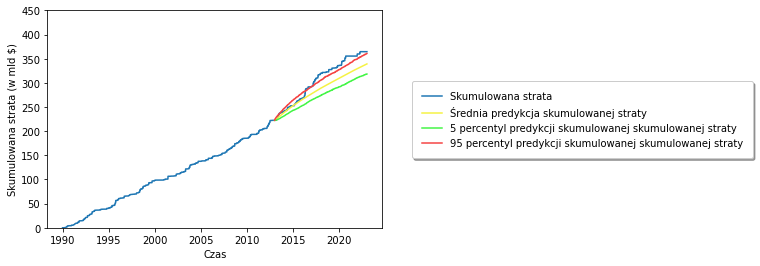

In [188]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_weibull_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_weibull_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_weibull_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")
ax= plt.gca()
ax.set_ylim([0,450])

plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_weibull_power_law_gan_avg.pdf",bbox_inches='tight')
plt.show()

### Rozkład Burra

Sinusoidalna funkcja intensywności

In [136]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(sin_int_fun,sin_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.burr12.rvs(c=burr_c_gan_avg,d=burr_k_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_sin_burr_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_sin_burr_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_sin_burr_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_sin_burr_gan = np.sum(MSE_array)/number_of_simulations
MAE_sin_burr_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [55:18<00:00,  6.64s/it]


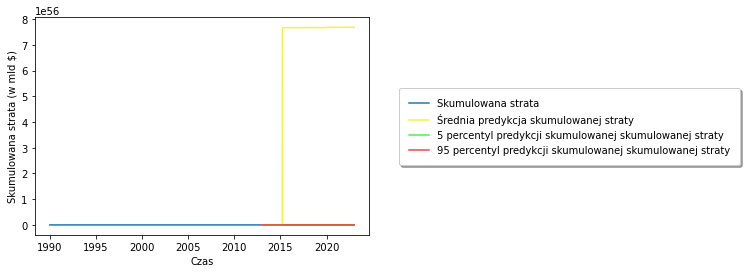

In [173]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_sin_burr_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_sin_burr_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_sin_burr_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_burr_sin_gan_avg.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności Power Law

In [138]:
cum_losses = []
MSE_array = []
MAE_array = []

for i in tqdm(range(number_of_simulations)):
    N_loss = nhpp(power_law_int_fun,power_law_params_gan_avg,len(np.floor(T_test['t']).unique()))
    damages_loss = np.array([stats.burr12.rvs(c=burr_c_gan_avg,d=burr_k_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
    damages_loss_cum = loss_pred(t_test,N_loss[1],damages_loss, T_test['t'])['damages']
    cum_losses.append(damages_loss_cum)
    MSE_array.append(MSE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    MAE_array.append(MAE(cum_loss_test["damages"].tail(1),(damages_loss_cum.tail(1)+float(cum_loss_train.tail(1)['damages']))))
    
cum_losses_power_law_burr_gan_avg = pd.DataFrame({"damages":np.mean(cum_losses,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_burr_gan_5p = pd.DataFrame({"damages":np.percentile(cum_losses,5,axis=0)},index=cum_loss_test.index)
cum_losses_power_law_burr_gan_95p = pd.DataFrame({"damages":np.percentile(cum_losses,95,axis=0)},index=cum_loss_test.index)

MSE_power_law_burr_gan = np.sum(MSE_array)/number_of_simulations
MAE_power_law_burr_gan = np.sum(MAE_array)/number_of_simulations

100%|██████████| 500/500 [36:29<00:00,  4.38s/it]


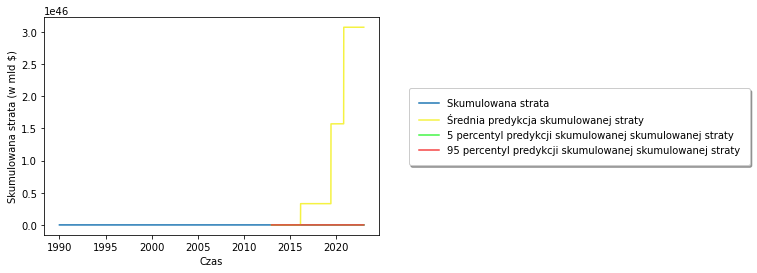

In [174]:
plt.plot(cum_loss_full["damages"]/1e6, linestyle= '-')
plt.plot((cum_losses_power_law_burr_gan_avg+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f5f242")
plt.plot((cum_losses_power_law_burr_gan_5p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#42f545")
plt.plot((cum_losses_power_law_burr_gan_95p+float(cum_loss_train.tail(1)['damages']))/1e6, linestyle= '-',color="#f54242")


plt.xlabel("Czas")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Średnia predykcja skumulowanej straty','5 percentyl predykcji skumulowanej skumulowanej straty','95 percentyl predykcji skumulowanej skumulowanej straty'],loc='right', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=[1.77,0.5])

plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\cum_loss_burr_power_law_gan_avg.pdf",bbox_inches='tight')
plt.show()

### Wyniki

In [140]:
# Wyniki

print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla", "Burra", "Burra"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'MSE':["{:e}".format(MSE_sin_exp_gan),"{:e}".format(MSE_power_law_exp_gan),"{:e}".format(MSE_sin_ln_gan),"{:e}".format(MSE_power_law_ln_gan),"{:e}".format(MSE_sin_gamma_gan),"{:e}".format(MSE_power_law_gamma_gan),"{:e}".format(MSE_sin_weibull_gan),"{:e}".format(MSE_power_law_weibull_gan),"{:e}".format(MSE_sin_burr_gan),"{:e}".format(MSE_power_law_burr_gan)],
    'MAE':["{:e}".format(MAE_sin_exp_gan),"{:e}".format(MAE_power_law_exp_gan),"{:e}".format(MAE_sin_ln_gan),"{:e}".format(MAE_power_law_ln_gan),"{:e}".format(MAE_sin_gamma_gan),"{:e}".format(MAE_power_law_gamma_gan),"{:e}".format(MAE_sin_weibull_gan),"{:e}".format(MAE_power_law_weibull_gan),"{:e}".format(MAE_sin_burr_gan),"{:e}".format(MAE_power_law_burr_gan)]                                            
}))

       rozkład       funkcja            MSE           MAE
0  Wykładniczy  Sinusoidalna   7.116361e+16  2.663408e+08
1  Wykładniczy     Power Law   3.950824e+16  1.984057e+08
2  Lognormalny  Sinusoidalna   8.691817e+16  2.934319e+08
3  Lognormalny     Power Law   4.640123e+16  2.143389e+08
4        Gamma  Sinusoidalna   7.105422e+16  2.660893e+08
5        Gamma     Power Law   3.951875e+16  1.983916e+08
6     Weibulla  Sinusoidalna   7.129437e+16  2.665011e+08
7     Weibulla     Power Law   3.900875e+16  1.970990e+08
8        Burra  Sinusoidalna  2.938034e+128  7.682758e+62
9        Burra     Power Law  1.947803e+107  3.071039e+52


In [152]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla", "Burra", "Burra"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'MSE':[MSE_sin_exp_gan,MSE_power_law_exp_gan,MSE_sin_ln_gan,MSE_power_law_ln_gan,MSE_sin_gamma_gan,MSE_power_law_gamma_gan,MSE_sin_weibull_gan,MSE_power_law_weibull_gan,MSE_sin_burr_gan,MSE_power_law_burr_gan],
    'MAE':[MAE_sin_exp_gan,MAE_power_law_exp_gan,MAE_sin_ln_gan,MAE_power_law_ln_gan,MAE_sin_gamma_gan,MAE_power_law_gamma_gan,MAE_sin_weibull_gan,MAE_power_law_weibull_gan,MAE_sin_burr_gan,MAE_power_law_burr_gan]                                            
}))

       rozkład       funkcja            MSE           MAE
0  Wykładniczy  Sinusoidalna   7.116361e+16  2.663408e+08
1  Wykładniczy     Power Law   3.950824e+16  1.984057e+08
2  Lognormalny  Sinusoidalna   8.691817e+16  2.934319e+08
3  Lognormalny     Power Law   4.640123e+16  2.143389e+08
4        Gamma  Sinusoidalna   7.105422e+16  2.660893e+08
5        Gamma     Power Law   3.951875e+16  1.983916e+08
6     Weibulla  Sinusoidalna   7.129437e+16  2.665011e+08
7     Weibulla     Power Law   3.900875e+16  1.970990e+08
8        Burra  Sinusoidalna  2.938034e+128  7.682758e+62
9        Burra     Power Law  1.947803e+107  3.071039e+52


In [184]:
print(pd.DataFrame
({
    'model': ['GAN','GAN','GAN','GAN','GAN','GAN','GAN','GAN'],
    'rozkład':['Wykładniczy','Wykładniczy', "Lognormalny", "Lognormalny", "Gamma", "Gamma", "Weibulla", "Weibulla"],
    'funkcja':['Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law','Sinusoidalna','Power Law'],
    'Zaobserwowana liczba':[float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6,float(cum_loss_full["damages"].tail(1))/1e6],
    '5 percentyl':[(float(cum_losses_sin_exp_gan_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_gan_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_gan_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_gan_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_gan_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_gan_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_gan_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_gan_5p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6],
    'Średnia predykcja':[(float(cum_losses_sin_exp_gan_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_gan_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_gan_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_gan_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_gan_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_gan_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_gan_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_gan_avg['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6],
    '95 percentyl':[(float(cum_losses_sin_exp_gan_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_exp_gan_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_ln_gan_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_ln_gan_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_gamma_gan_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_gamma_gan_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_sin_weibull_gan_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6,(float(cum_losses_power_law_weibull_gan_95p['damages'].tail(1))+float(cum_loss_train.tail(1)['damages']))/1e6]
}))

  model      rozkład       funkcja  Zaobserwowana liczba  5 percentyl  \
0   GAN  Wykładniczy  Sinusoidalna            364.515701   385.287421   
1   GAN  Wykładniczy     Power Law            364.515701   319.423436   
2   GAN  Lognormalny  Sinusoidalna            364.515701   396.640059   
3   GAN  Lognormalny     Power Law            364.515701   325.528023   
4   GAN        Gamma  Sinusoidalna            364.515701   383.914647   
5   GAN        Gamma     Power Law            364.515701   319.011043   
6   GAN     Weibulla  Sinusoidalna            364.515701   380.973996   
7   GAN     Weibulla     Power Law            364.515701   318.289201   

   Średnia predykcja  95 percentyl  
0         408.415148    434.348946  
1         340.480032    358.387186  
2         435.506274    484.988891  
3         356.413261    394.522926  
4         408.163602    435.180304  
5         340.465912    361.004749  
6         408.575444    436.118255  
7         339.173339    360.844545  


Rozkład parametrów otrzymanych poprzez dopasowywanie do danych syntentycznych.

exp_lambda_gan


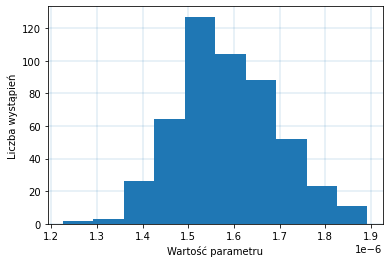

ln_mu_gan


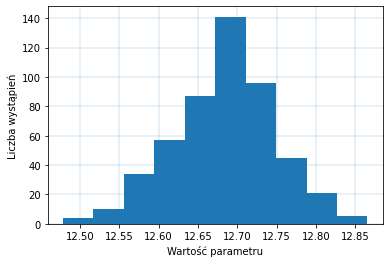

ln_sigma_sq_gan


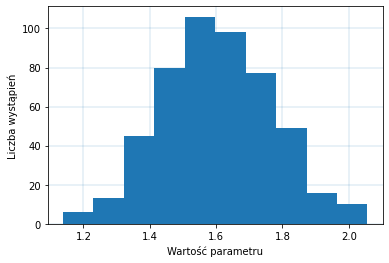

gamma_alfa_gan


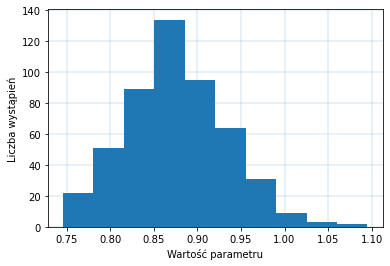

gamma_beta_gan


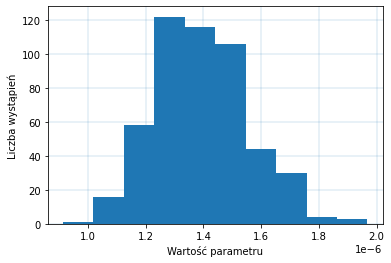

weibull_k_gan


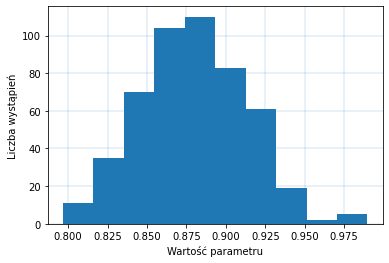

weibull_lambda_gan


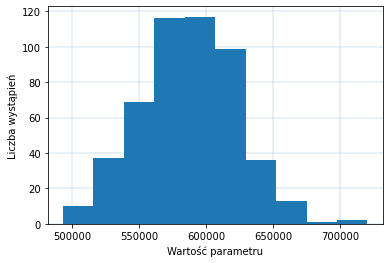

burr_c_gan


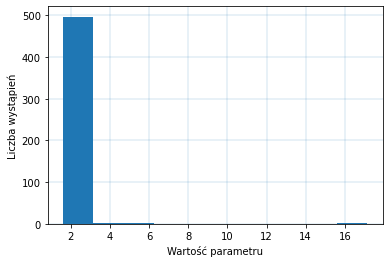

burr_k_gan


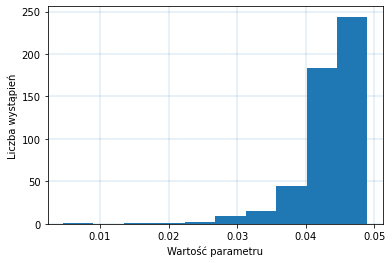

In [151]:
names = ["exp_lambda_gan" ,"ln_mu_gan" ,"ln_sigma_sq_gan" ,"gamma_alfa_gan" ,"gamma_beta_gan" ,"weibull_k_gan" ,"weibull_lambda_gan" ,"burr_c_gan" ,"burr_k_gan"]
j = 0

for i in [exp_lambda_gan ,
ln_mu_gan ,
ln_sigma_sq_gan ,
gamma_alfa_gan ,
gamma_beta_gan ,
weibull_k_gan ,
weibull_lambda_gan ,
burr_c_gan ,
burr_k_gan]:
    plt.hist(i)
    plt.xlabel("Wartość parametru")
    plt.ylabel("Liczba wystąpień")
    plt.grid(color='C0', linestyle='-', linewidth=0.2)
    plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\"+names[j]+"_distribution.pdf",bbox_inches='tight')
    print(names[j])
    j += 1
    plt.show()

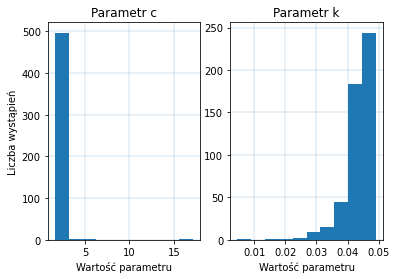

In [164]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(burr_c_gan)
axs[1].hist(burr_k_gan)
axs[0].set(xlabel = "Wartość parametru", ylabel = "Liczba wystąpień")
axs[0].grid(color='C0', linestyle='-', linewidth=0.2)
axs[0].set_title('Parametr c')
axs[1].set(xlabel = "Wartość parametru")
axs[1].grid(color='C0', linestyle='-', linewidth=0.2)
axs[1].set_title('Parametr k')
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\Symulacje GAN\\burr_gan_distribution.pdf",bbox_inches='tight')
plt.show()

## Proces ryzyka

In [178]:
rp_number_of_simulations = 1000

In [180]:
def ruin_prob_gan(u, theta, mu, lambda_func, lambda_func_params, loss_distribution, t_max, n):
    """
    Funkcja generuje niejednorodny proces Poissona metodą przerzerzedzania.

    Argumenty:
        u: float
            Kapitał początkowy
        theta: float
            Narzut
        mu: float
            Wartość oczekiwana X
        lambda_func: funkcja
            Funkcja intensywności
        loss_distribution: string
            Rozkład strat
        t_max: float
            Maksymalny czas symulacji
        n: int
            Liczba symulacji
    Zwraca:
        numpy.ndarray
            Tablica procesu ryzyka
    """
    negative = 0
    cum_losses = []
    MSE_array = []
    MAE_array = []
    I = integrate.quad(lambda x: lambda_func(x,lambda_func_params)[0],0, t_max)[0]
    C=(1+theta)*mu*I

    T = pd.DataFrame({'t':[t/365 for t in range((datetime.datetime(1990,12,31)-datetime.datetime(1990,1,1)).days+1)]})
    for r in range(1,t_max):
        if r%4==0:
            T = pd.concat([T,pd.DataFrame({'t':[r + t/366 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
        else:
            T = pd.concat([T,pd.DataFrame({'t':[r + t/365 for t in range((datetime.datetime(r,12,31)-datetime.datetime(r,1,1)).days+1)]})])
    T.reset_index(drop=True,inplace=True)

    for i in tqdm(range(n)):
        N_loss = nhpp(lambda_func,lambda_func_params,len(np.floor(T['t']).unique()))

        if loss_distribution == "expon":
            damages_loss = np.array([stats.expon.rvs(scale=1/exp_lambda_gan_avg,loc=0,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "lognormal":
            damages_loss = np.array([stats.lognorm.rvs(s=np.sqrt(ln_sigma_sq_gan_avg),scale=np.exp(ln_mu_gan_avg),size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "gamma":
            damages_loss = np.array([stats.gamma.rvs(a=gamma_alfa_gan_avg,scale=1/gamma_beta_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "weibull":
            damages_loss = np.array([stats.weibull_min.rvs(c=weibull_k_gan_avg,scale=weibull_lambda_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()
        elif loss_distribution == "burr":
            damages_loss = np.array([stats.burr12.rvs(c=burr_c_gan_avg,d=burr_k_gan_avg,size=1) for i in range(len(N_loss[1]))]).flatten()

        damages_loss_cum = loss_pred(T['t'],N_loss[1],damages_loss, T['t'])['damages']

        R = u + C - damages_loss_cum
        if np.sum(R<0) > 0:
            negative += 1

    return(negative/n)

In [ ]:
rp_5_expon_power_law_gan = ruin_prob_gan(1e7,0.3,1/exp_lambda_gan_avg,power_law_int_fun,power_law_params_gan_avg,"expon",5,rp_number_of_simulations)
rp_10_expon_power_law_gan = ruin_prob_gan(1e7,0.3,1/exp_lambda_gan_avg,power_law_int_fun,power_law_params_gan_avg,"expon",10,rp_number_of_simulations)
rp_15_expon_power_law_gan = ruin_prob_gan(1e7,0.3,1/exp_lambda_gan_avg,power_law_int_fun,power_law_params_gan_avg,"expon",15,rp_number_of_simulations)
rp_20_expon_power_law_gan = ruin_prob_gan(1e7,0.3,1/exp_lambda_gan_avg,power_law_int_fun,power_law_params_gan_avg,"expon",20,rp_number_of_simulations)
rp_50_expon_power_law_gan = ruin_prob_gan(1e7,0.3,1/exp_lambda_gan_avg,power_law_int_fun,power_law_params_gan_avg,"expon",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [17:07:41<00:00, 61.66s/it] 


In [ ]:
rp_5_gamma_power_law_gan = ruin_prob_gan(1e7,0.3,gamma_alfa_gan_avg/gamma_beta_gan_avg,power_law_int_fun,power_law_params_gan_avg,"gamma",5,rp_number_of_simulations)
rp_10_gamma_power_law_gan = ruin_prob_gan(1e7,0.3,gamma_alfa_gan_avg/gamma_beta_gan_avg,power_law_int_fun,power_law_params_gan_avg,"gamma",10,rp_number_of_simulations)
rp_15_gamma_power_law_gan = ruin_prob_gan(1e7,0.3,gamma_alfa_gan_avg/gamma_beta_gan_avg,power_law_int_fun,power_law_params_gan_avg,"gamma",15,rp_number_of_simulations)
rp_20_gamma_power_law_gan = ruin_prob_gan(1e7,0.3,gamma_alfa_gan_avg/gamma_beta_gan_avg,power_law_int_fun,power_law_params_gan_avg,"gamma",20,rp_number_of_simulations)
rp_50_gamma_power_law_gan = ruin_prob_gan(1e7,0.3,gamma_alfa_gan_avg/gamma_beta_gan_avg,power_law_int_fun,power_law_params_gan_avg,"gamma",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [17:24:11<00:00, 62.65s/it]  


In [182]:
rp_5_weibull_power_law_gan = ruin_prob_gan(1e7,0.3,weibull_lambda_gan_avg*gamma(1+1/weibull_k_gan_avg),power_law_int_fun,power_law_params_gan_avg,"weibull",5,rp_number_of_simulations)
rp_10_weibull_power_law_gan = ruin_prob_gan(1e7,0.3,weibull_lambda_gan_avg*gamma(1+1/weibull_k_gan_avg),power_law_int_fun,power_law_params_gan_avg,"weibull",10,rp_number_of_simulations)
rp_15_weibull_power_law_gan = ruin_prob_gan(1e7,0.3,weibull_lambda_gan_avg*gamma(1+1/weibull_k_gan_avg),power_law_int_fun,power_law_params_gan_avg,"weibull",15,rp_number_of_simulations)
rp_20_weibull_power_law_gan = ruin_prob_gan(1e7,0.3,weibull_lambda_gan_avg*gamma(1+1/weibull_k_gan_avg),power_law_int_fun,power_law_params_gan_avg,"weibull",20,rp_number_of_simulations)
rp_50_weibull_power_law_gan = ruin_prob_gan(1e7,0.3,weibull_lambda_gan_avg*gamma(1+1/weibull_k_gan_avg),power_law_int_fun,power_law_params_gan_avg,"weibull",50,rp_number_of_simulations)

100%|██████████| 1000/1000 [19:50:03<00:00, 71.40s/it]   


In [183]:
print(pd.DataFrame
({
    'rozkład':["Weibulla"],
    'funkcja':['Power Law'],
    '5 lat':[rp_5_weibull_power_law_gan],
    '10 lat':[rp_10_weibull_power_law_gan],
    '15 lat':[rp_15_weibull_power_law_gan],
    '20 lat':[rp_20_weibull_power_law_gan],
    '50 lat':[rp_50_weibull_power_law_gan],
}))

    rozkład    funkcja  5 lat  10 lat  15 lat  20 lat  50 lat
0  Weibulla  Power Law    0.0     0.0     0.0     0.0     0.0
